STEP 1: Libraries loaded. Seed set to 42
STEP 2: Text cleaning function defined.

STEP 3: Trying to auto-load the LIAR dataset from `datasets`...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Auto-load failed: 'utf-8' codec can't decode byte 0x8b in position 1: invalid start byte
If you're in Colab, upload a CSV with columns ['text','label'] (label: 1=fake,0=real).


Saving fake_news_sample.csv to fake_news_sample.csv
Uploaded file fake_news_sample.csv with shape (6, 2)

STEP 4: Dataset preview and class balance:


,text,label
0,Breaking news: Scientists discovered chocolate...,1
1,Government announces new policy to support sma...,0
2,Aliens landed in New York and are talking to h...,1
3,The local school board approves new education ...,0
4,COVID-19 vaccines are safe and effective accor...,0


label
1    3
0    3
Name: count, dtype: int64

STEP 5: Cleaning text (lowercasing, removing URLs/symbols)... This may take a moment.
Sample cleaned text:
breaking news scientists discovered chocolate cures all diseases
Cleaning done in 0.00s. Dropping empty rows...
After cleaning shape: (6, 3)

STEP 6: Splitting into train/test (stratified)...
Train size: (4, 3) Test size: (2, 3)

STEP 7: Training TF-IDF + Logistic Regression baseline.
Fitting TF-IDF on training text...
X_train shape: (4, 46)
Fitting LogisticRegression (this may take ~10-60s depending on dataset size)...
Training finished in 0.02s

STEP 8: Evaluating baseline on test set...
Results -> Accuracy: 0.5000  Precision: 0.5000  Recall: 1.0000  F1: 0.6667

Classification report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.50      1.00      0.67         1

    accuracy                           0.50         2
   macro avg       0.25      0.50 

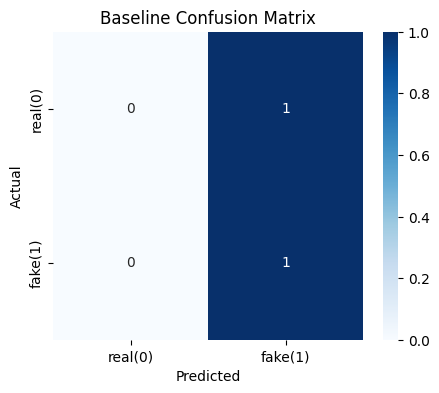


STEP 9: Creating an explanation helper so you can 'see why' the model predicted what it did.

Demo explain for example text:

INPUT TEXT (cleaned): breaking new study claims chocolate cures all diseases and scientists are stunned
Prediction:  1 (1=fake, 0=real)
Model probability for 'fake': 0.518

Top features pushing toward FAKE (positive contribution):
  claims                -> +0.101621
  new                   -> -0.035299

Top features pushing toward REAL (negative contribution):
  new                   -> -0.035299
  claims                -> +0.101621

STEP 10: Saving baseline model and vectorizer to './models' folder...
Saved: models/tfidf_lr_clf.joblib and models/tfidf_vectorizer.joblib

STEP 12: Interactive test. Type some news text to see prediction & explanation.
Type 'exit' to quit the interactive loop.


INPUT TEXT (cleaned): aliens have landed in paris and started negotiating with world leaders
Prediction:  1 (1=fake, 0=real)
Model probability for 'fake': 0.556

Top feat

In [ ]:
# === Fake News Detection: Step-by-step (verbose, Colab-ready) ===
# Paste into one Colab cell and run.
# This script:
# 1) Attempts to load the LIAR dataset (auto) or lets you upload a CSV.
# 2) Preprocesses text and shows dataset diagnostics.
# 3) Trains a TF-IDF + LogisticRegression baseline (fast).
# 4) Evaluates and prints metrics & confusion matrix.
# 5) Provides an explanation helper showing which words influenced the decision.
# 6) Optional: small DistilBERT fine-tuning (disabled by default).
# 7) Interactive loop to try example texts and "see what happens".

# -------------------------
# 0) Install dependencies (uncomment if running fresh in Colab)
# -------------------------
# !pip -q install --upgrade pip
# !pip -q install scikit-learn pandas matplotlib seaborn datasets transformers evaluate torch joblib tqdm --progress-bar off

# -------------------------
# 1) Imports & seeds
# -------------------------
import time, os, random, re
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
import joblib
from tqdm.auto import tqdm

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
print("STEP 1: Libraries loaded. Seed set to", SEED)

# -------------------------
# 2) Text cleaning helper
# -------------------------
def clean_text(s):
    # simple cleaning: lowercase, remove urls, remove repeated spaces
    s = str(s).lower()
    s = re.sub(r'http\S+|www\.\S+', ' ', s)                # remove urls
    s = re.sub(r'<.*?>', ' ', s)                          # remove html tags
    s = re.sub(r'[^a-z0-9\s]', ' ', s)                    # keep alphanum + space
    s = re.sub(r'\s+', ' ', s).strip()
    return s

print("STEP 2: Text cleaning function defined.")

# -------------------------
# 3) Load dataset (try LIAR, else ask upload)
# -------------------------
def load_data():
    print("\nSTEP 3: Trying to auto-load the LIAR dataset from `datasets`...")
    try:
        ds = load_dataset("liar")
        # Convert to a simple DataFrame with binary labels:
        # LIAR labels: 0..5  (pants-fire, false, barely-true, half-true, mostly-true, true)
        # We map 0,1,2 -> fake (1) and 3,4,5 -> real (0) as a simple binary mapping.
        def convert(ex):
            text = ex.get('statement') or ex.get('text') or ""
            label_bin = 1 if ex['label'] <= 2 else 0
            return {"text": text, "label": label_bin}
        print("Converting LIAR splits to single dataframe (binary labels)...")
        df_train = pd.DataFrame(ds['train'].map(convert))
        df_test = pd.DataFrame(ds['test'].map(convert))
        # validation may not exist in older versions; concatenate what's available
        parts = [df_train, df_test]
        if 'validation' in ds:
            parts.append(pd.DataFrame(ds['validation'].map(convert)))
        df = pd.concat(parts, ignore_index=True).dropna(subset=['text']).reset_index(drop=True)
        print("Loaded LIAR dataset; shape:", df.shape)
        return df
    except Exception as e:
        print("Auto-load failed:", e)
        print("If you're in Colab, upload a CSV with columns ['text','label'] (label: 1=fake,0=real).")
        try:
            from google.colab import files
            uploaded = files.upload()
            fn = list(uploaded.keys())[0]
            df = pd.read_csv(fn)
            # try to find columns
            if 'text' not in df.columns:
                for c in df.columns:
                    if c.lower() in ('content','article','statement','body'):
                        df = df.rename(columns={c:'text'}); break
            if 'label' not in df.columns:
                for c in df.columns:
                    if c.lower() in ('label','target','fake'):
                        df = df.rename(columns={c:'label'}); break
            assert 'text' in df.columns and 'label' in df.columns
            print("Uploaded file", fn, "with shape", df.shape)
            return df[['text','label']]
        except Exception as e2:
            raise RuntimeError("Could not load dataset automatically. If using Colab, re-run and upload a CSV.") from e2

df = load_data()

# Show a quick preview & class balance
print("\nSTEP 4: Dataset preview and class balance:")
display(df.head(5))
print(df['label'].value_counts(dropna=False))

# -------------------------
# 4) Preprocess text & split
# -------------------------
print("\nSTEP 5: Cleaning text (lowercasing, removing URLs/symbols)... This may take a moment.")
t0 = time.time()
df['text_clean'] = df['text'].astype(str).map(clean_text)
print("Sample cleaned text:")
print(df['text_clean'].iloc[0])
print(f"Cleaning done in {time.time()-t0:.2f}s. Dropping empty rows...")
df = df[df['text_clean'].str.strip() != ""].reset_index(drop=True)
print("After cleaning shape:", df.shape)

# Train-test split
print("\nSTEP 6: Splitting into train/test (stratified)...")
train_df, test_df = train_test_split(df, test_size=0.2, random_state=SEED, stratify=df['label'])
print("Train size:", train_df.shape, "Test size:", test_df.shape)

# -------------------------
# 5) Train TF-IDF + Logistic Regression baseline
# -------------------------
print("\nSTEP 7: Training TF-IDF + Logistic Regression baseline.")
tfidf = TfidfVectorizer(max_features=20000, ngram_range=(1,2), stop_words='english')
print("Fitting TF-IDF on training text...")
X_train = tfidf.fit_transform(train_df['text_clean'].tolist())
X_test = tfidf.transform(test_df['text_clean'].tolist())
print("X_train shape:", X_train.shape)

clf = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=SEED)
t0 = time.time()
print("Fitting LogisticRegression (this may take ~10-60s depending on dataset size)...")
clf.fit(X_train, train_df['label'].values)
print("Training finished in {:.2f}s".format(time.time()-t0))

# -------------------------
# 6) Evaluate baseline & show what happened
# -------------------------
print("\nSTEP 8: Evaluating baseline on test set...")
preds = clf.predict(X_test)
probs = clf.predict_proba(X_test)[:,1] if hasattr(clf, "predict_proba") else None
acc = accuracy_score(test_df['label'], preds)
prec, rec, f1, _ = precision_recall_fscore_support(test_df['label'], preds, average='binary', zero_division=0)
print(f"Results -> Accuracy: {acc:.4f}  Precision: {prec:.4f}  Recall: {rec:.4f}  F1: {f1:.4f}")
print("\nClassification report:")
print(classification_report(test_df['label'], preds, zero_division=0))

print("\nConfusion matrix (rows: actual, cols: predicted):")
cm = confusion_matrix(test_df['label'], preds)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['real(0)','fake(1)'], yticklabels=['real(0)','fake(1)'])
plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.title('Baseline Confusion Matrix')
plt.show()

# -------------------------
# 7) Explanation helper: "What happened and why?"
# -------------------------
print("\nSTEP 9: Creating an explanation helper so you can 'see why' the model predicted what it did.")

feature_names = tfidf.get_feature_names_out()
coef = clf.coef_[0]  # coefficient per feature; positive -> towards label 1 (fake), negative -> towards 0 (real)

def explain_baseline(text, top_n=10):
    """
    Returns:
      - predicted label (0=real, 1=fake)
      - probability for label 1 (if available)
      - top_n contributing words pushing toward fake and toward real
    """
    cleaned = clean_text(text)
    vec = tfidf.transform([cleaned])
    pred = clf.predict(vec)[0]
    prob = clf.predict_proba(vec)[0][1] if hasattr(clf, "predict_proba") else None

    # extract non-zero features from TF-IDF vector
    v_ind = vec.nonzero()[1]
    v_data = vec.data
    contributions = {}
    # we'll compute contribution = tfidf_value * coef(feature)
    for idx_i, feat_idx in enumerate(v_ind):
        tfidf_val = vec.data[idx_i]
        contributions[feat_idx] = tfidf_val * coef[feat_idx]

    # rank features by contribution
    ranked = sorted(contributions.items(), key=lambda x: x[1], reverse=True)
    top_fake = [(feature_names[i], round(val,6)) for i,val in ranked[:top_n]]
    top_real = [(feature_names[i], round(val,6)) for i,val in ranked[-top_n:]][::-1]

    print("\nINPUT TEXT (cleaned):", cleaned)
    print("Prediction: ", pred, "(1=fake, 0=real)")
    if prob is not None:
        print("Model probability for 'fake': {:.3f}".format(prob))
    print("\nTop features pushing toward FAKE (positive contribution):")
    for w,c in top_fake:
        print(f"  {w:20s}  -> {c:+.6f}")
    print("\nTop features pushing toward REAL (negative contribution):")
    for w,c in top_real:
        print(f"  {w:20s}  -> {c:+.6f}")

    return {"pred": int(pred), "prob_fake": float(prob) if prob is not None else None,
            "top_fake": top_fake, "top_real": top_real}

# Quick demo explanation
demo_text = "Breaking: New study claims chocolate cures all diseases and scientists are stunned."
print("\nDemo explain for example text:")
explain_baseline(demo_text, top_n=6)

# -------------------------
# 8) Save baseline model and vectorizer
# -------------------------
print("\nSTEP 10: Saving baseline model and vectorizer to './models' folder...")
Path("models").mkdir(parents=True, exist_ok=True)
joblib.dump(clf, "models/tfidf_lr_clf.joblib")
joblib.dump(tfidf, "models/tfidf_vectorizer.joblib")
print("Saved: models/tfidf_lr_clf.joblib and models/tfidf_vectorizer.joblib")

# -------------------------
# 9) Optional: DistilBERT fine-tuning (disabled by default)
# -------------------------
DO_FINETUNE = False   # set True to run transformer fine-tuning (needs GPU & time)
if DO_FINETUNE:
    print("\nSTEP 11: Fine-tuning DistilBERT (this is optional and heavy).")
    # Code omitted here for brevity; use the transformer fine-tuning block from the previous full script
    # (It will tokenize, run Trainer.train(), and save the model.)
    # If you want the full block, set DO_FINETUNE=True and run the extended fine-tune code.
    pass

# -------------------------
# 10) Interactive loop: paste text -> see what happens
# -------------------------
print("\nSTEP 12: Interactive test. Type some news text to see prediction & explanation.")
print("Type 'exit' to quit the interactive loop.\n")

while True:
    try:
        user = input("Enter text (or 'exit'): ").strip()
    except Exception:
        # in notebook UI, `input` works; if not, break
        print("Interactive input not available in this environment. Break.")
        break
    if user.lower() in ('exit','quit'):
        print("Exiting interactive loop.")
        break
    if not user:
        print("Empty input, try again.")
        continue
    out = explain_baseline(user, top_n=8)

print("\n--- ALL STEPS COMPLETE ---")
print("What happened summary:")
print(" - We loaded a dataset and converted labels to binary.")
print(" - Cleaned the text and split train/test.")
print(" - Trained a TF-IDF vectorizer and Logistic Regression classifier.")
print(" - Evaluated performance and plotted a confusion matrix.")
print(" - Provided an explanation helper that shows which words 'pushed' the decision.")
print("\nIf you want the optional DistilBERT finetune code added here, or a full `.ipynb` file exported, tell me and I will create it.")
